In [4]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from sklearn.utils.class_weight import compute_class_weight

In [16]:
def lr_schedule(epoch):
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 10.0  # Number of epochs after which learning rate should drop
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return max(lr,0.00001)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [11]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [12]:
class_weights = np.round(compute_class_weight('balanced',classes = np.arange(train_dataset.num_classes),y = train_dataset.labels),2)
class_weights_dict = dict(zip(np.arange(train_dataset.num_classes), class_weights))

In [18]:

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Load pre-trained ResNet50 model with pre-trained weights and without top layers
    base_model = ResNet50(weights='imagenet', include_top=False)

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation = 'relu')(x)
    x = Dense(1024,activation = 'relu')(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['categorical_accuracy'])
    
    history = model.fit(train_dataset, validation_data=val_dataset,  epochs=100,callbacks=[LearningRateScheduler(lr_schedule),early_stopping],class_weight=class_weights_dict)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
463/463 [==============================] - 112s 213ms/step - loss: 1.3528 - categorical_accuracy: 0.2936 - val_loss: 1.2747 - val_categorical_accuracy: 0.4063
Epoch 2/100
463/463 [==============================] - 93s 202ms/step - loss: 1.2314 - categorical_accuracy: 0.3756 - val_loss: 1.1653 - val_categorical_accuracy: 0.5507
Epoch 3/100
463/463 [==============================] - 89s 192ms/step - loss: 1.1392 - categorical_accuracy: 0.4469 - val_loss: 1.3472 - val_categorical_accuracy: 0.3492
Epoch 4/100
463/463 [==============================] - 89s 193ms/step - lo

463/463 [==============================] - 89s 192ms/step - loss: 0.6024 - categorical_accuracy: 0.7032 - val_loss: 0.7011 - val_categorical_accuracy: 0.7074
Epoch 47/100
463/463 [==============================] - 90s 194ms/step - loss: 0.6035 - categorical_accuracy: 0.7033 - val_loss: 0.6935 - val_categorical_accuracy: 0.7121
Epoch 48/100
463/463 [==============================] - 90s 195ms/step - loss: 0.6017 - categorical_accuracy: 0.7015 - val_loss: 0.6409 - val_categorical_accuracy: 0.7395
Epoch 49/100
463/463 [==============================] - 90s 194ms/step - loss: 0.6013 - categorical_accuracy: 0.7022 - val_loss: 0.6704 - val_categorical_accuracy: 0.7244
Epoch 50/100
463/463 [==============================] - 92s 199ms/step - loss: 0.5988 - categorical_accuracy: 0.7043 - val_loss: 0.7195 - val_categorical_accuracy: 0.6951
Epoch 51/100
463/463 [==============================] - 93s 201ms/step - loss: 0.6007 - categorical_accuracy: 0.7045 - val_loss: 0.6781 - val_categorical_accu

Epoch 94/100
463/463 [==============================] - 90s 194ms/step - loss: 0.5612 - categorical_accuracy: 0.7239 - val_loss: 0.6372 - val_categorical_accuracy: 0.7433
Epoch 95/100
463/463 [==============================] - 91s 197ms/step - loss: 0.5582 - categorical_accuracy: 0.7261 - val_loss: 0.6186 - val_categorical_accuracy: 0.7584
Epoch 96/100
463/463 [==============================] - 92s 198ms/step - loss: 0.5610 - categorical_accuracy: 0.7276 - val_loss: 0.7219 - val_categorical_accuracy: 0.6999
Epoch 97/100
463/463 [==============================] - 92s 199ms/step - loss: 0.5584 - categorical_accuracy: 0.7261 - val_loss: 0.6330 - val_categorical_accuracy: 0.7423
Epoch 98/100
463/463 [==============================] - 91s 196ms/step - loss: 0.5569 - categorical_accuracy: 0.7259 - val_loss: 0.6551 - val_categorical_accuracy: 0.7286
Epoch 99/100
463/463 [==============================] - 91s 196ms/step - loss: 0.5548 - categorical_accuracy: 0.7286 - val_loss: 0.6760 - val_cat

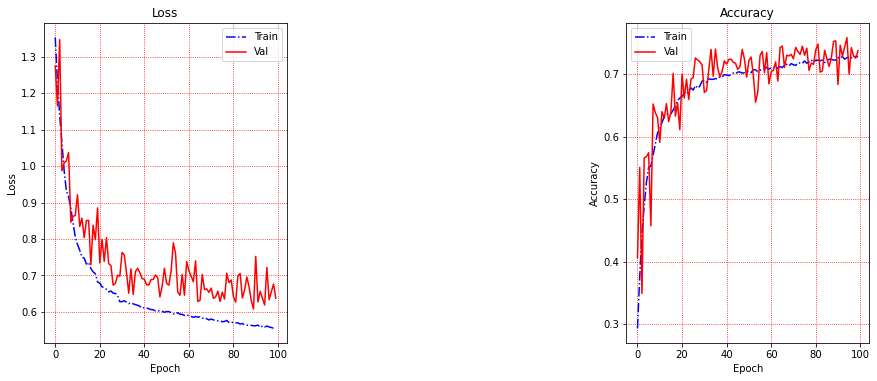

In [19]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['categorical_accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_categorical_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

133/133 [==============================] - 26s 182ms/step - loss: 0.6622 - categorical_accuracy: 0.7285
Test Loss: 0.662183940410614
Test Accuracy: 0.7284533381462097


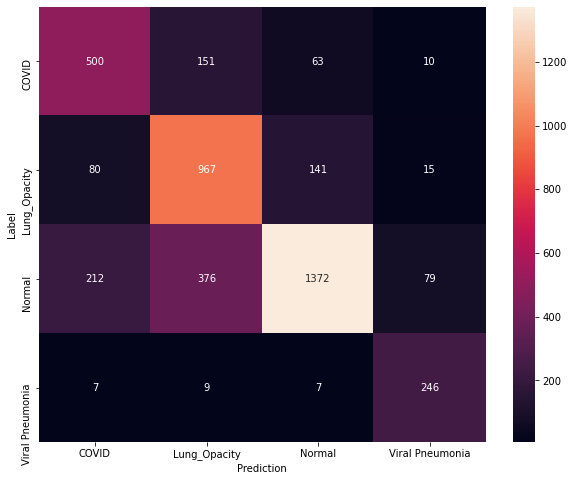

In [20]:
test_result = model.evaluate(test_dataset, batch_size = 128)

print('Test Loss: {}'.format(test_result[0]))
print('Test Accuracy: {}'.format(test_result[1]))

class_names = list(train_dataset.class_indices)

label_names = class_names
y_pred = model.predict(test_dataset, batch_size=128)
y_test = test_dataset.labels
cm = tf.math.confusion_matrix(y_test, 
                              y_pred.argmax(axis=1),
                              num_classes = 4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
              annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('CM.png', dpi = 300)
plt.show()